In [1]:
import pandas as pd
import numpy as np

In [38]:
sig = pd.read_hdf('higgs_signal.h5')
bkg = pd.read_hdf('higgs_bkg.h5')

In [39]:
sig.head()

,lepton_pT,lepton_eta,lepton_phi,missing_energy_magnitude,missing_energy_phi,jet1_pt,jet1_eta,jet1_phi,jet1_btag,jet2_pt,...,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,label
0,0.723801,-0.914611,0.910944,1.194830,-0.448292,0.839489,-0.871428,0.587799,0.000000,0.654446,...,-0.916982,3.101961,0.867059,1.127180,1.211664,0.695883,0.694068,0.755813,0.761658,0
1,1.974119,0.660297,-1.362428,1.234102,1.677716,1.478815,0.408940,-0.105273,0.000000,1.017048,...,1.604089,3.101961,1.938668,1.233898,0.990063,0.524871,0.900614,0.917613,1.083369,0
2,0.946889,0.169416,1.210014,0.343294,-1.579545,0.999435,1.030804,-0.475041,0.000000,0.435374,...,0.558635,3.101961,0.881641,0.845381,0.997408,0.695120,0.787132,0.657668,0.721147,0
3,1.298084,-0.897079,1.224441,0.618091,0.856746,0.493122,-0.021810,-1.520042,2.173076,0.973234,...,0.581386,0.000000,0.848238,0.925814,0.973957,0.961469,0.946147,1.028120,0.848133,0
4,1.022289,-0.481195,0.169649,1.103255,0.744424,1.648197,-0.780327,-1.484007,2.173076,0.675472,...,-0.284934,1.550981,0.717778,0.752909,0.996800,1.648921,1.138676,1.118826,0.977200,0


In [40]:
data = pd.concat([sig, bkg])

In [8]:
selected_features = ['m_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb', 'label']
data_red = data[selected_features]

In [18]:
features = data.drop(['label'], axis=1).values
labels = data[['label']].values.ravel()

In [10]:
num_samples = features.shape[0]
num_feature_elements = features.shape[1]

In [7]:
sol_per_pop = 12 # Population size.
num_parents_mating = 6 # Number of parents inside the mating pool.
num_mutations = 3 # Number of elements to mutate.

# Defining the population shape.
pop_shape = (sol_per_pop, num_feature_elements)

In [8]:
# Creating the initial population.
new_population = np.random.randint(low=0, high=2, size=pop_shape)
print(new_population.shape)

best_outputs = []
num_generations = 100

(12, 28)


In [32]:
import ga

In [10]:
import importlib
importlib.reload(ga)

<module 'ga' from '/eos/home-l/llayer/Higgs/ga.py'>

In [11]:
for generation in range(num_generations):
    print("Generation : ", generation)
    
    # Measuring the fitness of each chromosome in the population.
    fitness = ga.cal_pop_fitness(new_population, features, labels)

    print( fitness )
    
    best_outputs.append(np.max(fitness))
    # The best result in the current iteration.
    print("Best result : ", best_outputs[-1])

    # Selecting the best parents in the population for mating.
    parents = ga.select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
    offspring_crossover = ga.crossover(parents, offspring_size=(pop_shape[0]-parents.shape[0], num_feature_elements))

    # Adding some variations to the offspring using mutation.
    offspring_mutation = ga.mutation(offspring_crossover, num_mutations=num_mutations)

    # Creating the new population based on the parents and offspring.
    new_population[0:parents.shape[0], :] = parents
    new_population[parents.shape[0]:, :] = offspring_mutation

Generation :  0
0.7649215609763802
0.7243597508310788
0.7077711419219794
0.7361910134657782
0.7532368202172455
0.6846897910114087
0.6340605826400367
0.6978888360432611
0.6994038749916316
0.6489120509673887
0.7299963201933226
0.712091218431102
[0.76492156 0.72435975 0.70777114 0.73619101 0.75323682 0.68468979
 0.63406058 0.69788884 0.69940387 0.64891205 0.72999632 0.71209122]
Best result :  0.7649215609763802
Generation :  1
0.7649215609763802
0.7532368202172455
0.7361910134657782
0.7299963201933226
0.7243597508310788
0.712091218431102
0.7604326468187305
0.730922654357421
0.7470339995953774
0.7099249813507177
0.7266813258948648
0.7515285156548821
[0.76492156 0.75323682 0.73619101 0.72999632 0.72435975 0.71209122
 0.76043265 0.73092265 0.747034   0.70992498 0.72668133 0.75152852]
Best result :  0.7649215609763802
Generation :  2
0.7649215609763802
0.7604326468187305
0.7532368202172455
0.7515285156548821
0.7470339995953774
0.7361910134657782
0.7619016307870975
0.7622812744308354
0.7571398

0.7814711861586372
0.781323240848995
0.7810945271347401
0.781031345028574
0.78063411508639
0.7804979245871972
0.7728484357699248
0.7739565103237082
0.7715385549976815
0.7721805237668034
0.7719798195618228
0.7725531420746083
[0.78147119 0.78132324 0.78109453 0.78103135 0.78063412 0.78049792
 0.77284844 0.77395651 0.77153855 0.77218052 0.77197982 0.77255314]
Best result :  0.7814711861586372
Generation :  21
0.7814711861586372
0.781323240848995
0.7810945271347401
0.781031345028574
0.78063411508639
0.7804979245871972
0.7783290243075706
0.7787442078860268
0.7779445134376308
0.7791363410158674
0.7778335774140134
0.7782067926457865
[0.78147119 0.78132324 0.78109453 0.78103135 0.78063412 0.78049792
 0.77832902 0.77874421 0.77794451 0.77913634 0.77783358 0.77820679]
Best result :  0.7814711861586372
Generation :  22
0.7814711861586372
0.781323240848995
0.7810945271347401
0.781031345028574
0.78063411508639
0.7804979245871972
0.7722768581118157
0.7735154294284803
0.7709795127429033
0.77157469185

0.7819253075467076
0.7818933032385696
0.7815333121685522
0.7814711861586372
0.781323240848995
0.7810945271347401
0.7716566541089169
0.7726825827412382
0.7718000995301841
0.7719263719080602
0.7717272288888426
0.7734594104099315
[0.78192531 0.7818933  0.78153331 0.78147119 0.78132324 0.78109453
 0.77165665 0.77268258 0.7718001  0.77192637 0.77172723 0.77345941]
Best result :  0.7819253075467076
Generation :  41
0.7819253075467076
0.7818933032385696
0.7815333121685522
0.7814711861586372
0.781323240848995
0.7810945271347401
0.7754085049175974
0.7760490961698694
0.7762222041206304
0.7750617380093358
0.775823137489314
0.7766043732119258
[0.78192531 0.7818933  0.78153331 0.78147119 0.78132324 0.78109453
 0.7754085  0.7760491  0.7762222  0.77506174 0.77582314 0.77660437]
Best result :  0.7819253075467076
Generation :  42
0.7819253075467076
0.7818933032385696
0.7815333121685522
0.7814711861586372
0.781323240848995
0.7810945271347401
0.77845984249105
0.7792968676460689
0.7780211033744662
0.77827

0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.7722783274631217
0.7734121156647634
0.7729703460111106
0.7719861102221026
0.7711722732673846
0.7727643613248736
[0.7822324  0.78192531 0.7818933  0.78187246 0.78185978 0.78177447
 0.77227833 0.77341212 0.77297035 0.77198611 0.77117227 0.77276436]
Best result :  0.7822324019697021
Generation :  61
0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.7499529118823594
0.7504364202965537
0.7487590180288488
0.7493821148171316
0.7498214967749116
0.7497202952036975
[0.7822324  0.78192531 0.7818933  0.78187246 0.78185978 0.78177447
 0.74995291 0.75043642 0.74875902 0.74938211 0.7498215  0.7497203 ]
Best result :  0.7822324019697021
Generation :  62
0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.7714430012455507
0.7719044693901522
0.7700409186788437
0

0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.7302534566719066
0.7334530609755998
0.7285821154783396
0.7305022362149363
0.7285019899149237
0.7322068214818059
[0.7822324  0.78192531 0.7818933  0.78187246 0.78185978 0.78177447
 0.73025346 0.73345306 0.72858212 0.73050224 0.72850199 0.73220682]
Best result :  0.7822324019697021
Generation :  81
0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.760085053400359
0.7596902111540478
0.759089154635358
0.7602259274568404
0.7607908930340719
0.7602154583287839
[0.7822324  0.78192531 0.7818933  0.78187246 0.78185978 0.78177447
 0.76008505 0.75969021 0.75908915 0.76022593 0.76079089 0.76021546]
Best result :  0.7822324019697021
Generation :  82
0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818597836618972
0.7817744694516813
0.7803522751389708
0.7803478211678239
0.7808788998305563
0.7

In [12]:
from matplotlib import pyplot as plt

0.7822324019697021
0.7819253075467076
0.7818933032385696
0.7818724568169131
0.7818649263914688
0.7818597836618972
0.7717151526577948
0.7714571437518729
0.7712103386496606
0.7722144565985307
0.7714556284833383
0.7720901127442441
best_match_idx :  0
best_solution :  [1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1]
Selected indices :  [ 0  2  3  4  5  8  9 12 13 14 15 16 18 19 20 21 22 23 24 25 26 27]
Number of selected elements :  22
Best solution fitness :  0.7822324019697021


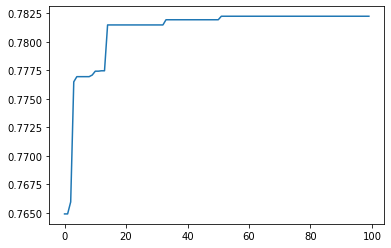

In [13]:

# Getting the best solution after iterating finishing all generations.
# At first, the fitness is calculated for each solution in the final generation.
fitness = ga.cal_pop_fitness(new_population, features, labels)
# Then return the index of that solution corresponding to the best fitness.
best_match_idx = np.where(fitness == np.max(fitness))[0]
best_match_idx = best_match_idx[0]

best_solution = new_population[best_match_idx, :]
best_solution_indices = np.where(best_solution == 1)[0]
best_solution_num_elements = best_solution_indices.shape[0]
best_solution_fitness = fitness[best_match_idx]

print("best_match_idx : ", best_match_idx)
print("best_solution : ", best_solution)
print("Selected indices : ", best_solution_indices)
print("Number of selected elements : ", best_solution_num_elements)
print("Best solution fitness : ", best_solution_fitness)

plt.plot(best_outputs)

In [20]:
import numpy
import sklearn.svm
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)

"""
SV_classifier = sklearn.svm.SVC(gamma='scale')
SV_classifier.fit(X=X_train, y=y_train)

predictions = SV_classifier.decision_function(X_test)#.predict(X_test)
score = roc_auc_score(y_test, predictions) # classification_accuracy(y_test, predictions)
print(score)
"""

"\nSV_classifier = sklearn.svm.SVC(gamma='scale')\nSV_classifier.fit(X=X_train, y=y_train)\n\npredictions = SV_classifier.decision_function(X_test)#.predict(X_test)\nscore = roc_auc_score(y_test, predictions) # classification_accuracy(y_test, predictions)\nprint(score)\n"

In [124]:
from keras.models import Sequential
from keras.optimizers import Adam, SGD
#from keras.initializers import TruncatedNormal
#from keras import initializations
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Reshape
#from keras.callbacks import ReduceLROnPlateau

# Define model
model = Sequential()
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh', input_dim=features.shape[1]))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
#model.add(Dropout(0.2))
model.add(Dense(64, kernel_initializer='glorot_normal', activation='tanh'))
model.add(Dense(1, kernel_initializer='glorot_uniform', activation='sigmoid'))

# Set loss and optimizer
model.compile(loss='binary_crossentropy', optimizer=Adam())

model.summary()

# Early stopping
patience = 10

es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100, 
                    epochs=1000, verbose=2, callbacks=[es])

predictions = model.predict(X_test)
print( roc_auc_score(y_test, predictions) )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_380 (Dense)            (None, 64)                1856      
_________________________________________________________________
dense_381 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_382 (Dense)            (None, 64)                4160      
_________________________________________________________________
dense_383 (Dense)            (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________
Train on 13400 samples, validate on 6600 samples
Epoch 1/1000
 - 7s - loss: 0.6746 - val_loss: 0.6591
Epoch 2/1000
 - 1s - loss: 0.6517 - val_loss: 0.6526
Epoch 3/1000
 - 1s - loss: 0.6456 - val_loss: 0.6546
Epoch 4/1000
 - 1s - loss: 0.6422 - val_loss: 0.6503
Epoch 5/1

In [21]:
import xgboost as xgb

# Early stopping
early_stopping_rounds = 5

# Define model
model_bdt = xgb.XGBClassifier(n_jobs = 4)

# Last in list is used for early stopping
eval_set = [(X_train, y_train), (X_test, y_test)]

# Fit with early stopping
model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
              early_stopping_rounds=early_stopping_rounds, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

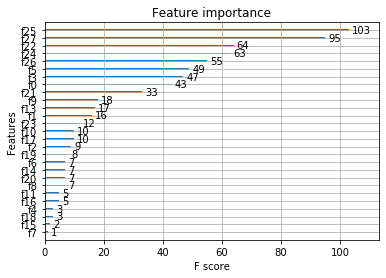

In [24]:
from xgboost import plot_importance
plot_importance(model_bdt)


In [27]:
type(model_bdt.feature_importances_)

numpy.ndarray

In [32]:
predictions = model_bdt.predict_proba(X_test)[:,1]
score = roc_auc_score(y_test, predictions)
print(score)

0.7805039397441069


In [33]:
fscore = model_bdt.feature_importances_

In [36]:
fscore = list(fscore)

In [41]:
feature_importance = pd.DataFrame(list(data.drop(['label'], axis=1)))

In [42]:
feature_importance['f-score'] = fscore

In [44]:
feature_importance.columns = ['feature', 'fscore']

In [49]:
feature_importance = feature_importance.sort_values(by=['fscore'], ascending=False)

In [50]:
feature_importance

,feature,fscore
25,m_bb,0.147746
26,m_wbb,0.101843
27,m_wwbb,0.073595
5,jet1_pt,0.069575
22,m_jjj,0.068811
24,m_jlv,0.050949
9,jet2_pt,0.046317
8,jet1_btag,0.045502
0,lepton_pT,0.035983
3,missing_energy_magnitude,0.033924


In [52]:
reduced_feat = feature_importance.iloc[0:5]

In [55]:
list(reduced_feat['feature'])

['m_bb', 'm_wbb', 'm_wwbb', 'jet1_pt', 'm_jjj']

In [14]:
fitness = pd.DataFrame(best_outputs)

In [15]:
fitness.to_hdf('xgb_sol_12_parents_6_mutations_3.h5', 'frame')

In [16]:
features.shape

(20000, 28)

In [85]:
from skopt.space import Real, Categorical, Integer

# Skopt dimensions
skopt_dims = [       
    Real(        low=1e-2, high=1,     prior='log-uniform', name='learning_rate'     ),
    Integer(        low=2,    high=20,                         name='max_depth'     ),
    Integer(        low=1,    high=20,                         name='min_child_weight'     ),
    Real(        low=1e-6, high=1e-2,     prior='log-uniform', name='reg_alpha'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]

# Initial parameters
init_param = {'learning_rate' : 0.3, 'reg_alpha' : 1e-5, 'max_depth' : 6, 'min_child_weight' : 1, 'n_feat':12 }

In [12]:
import keras
from keras.layers import Input, Flatten, Dense, Dropout, Reshape

Using TensorFlow backend.


In [13]:
def create_model( n_features, dense_layers, dense_units, regulizer_value, dropout_value, learning_rate ):

    m_input = Input(shape = (n_features, ))
    m = m_input
    
    for _ in range(dense_layers):
        m = Dense( units=dense_units, activation='relu', 
                   kernel_initializer='lecun_normal',
                   kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)
        m = Dropout(dropout_value)(m)

    m_output = Dense( units=1, activation='sigmoid', 
                      kernel_initializer='lecun_normal',
                      kernel_regularizer=keras.regularizers.l2(regulizer_value) )(m)

    model = keras.models.Model(inputs=m_input, outputs=m_output)
    model.compile( loss = 'binary_crossentropy',
                        optimizer = keras.optimizers.Adam(lr=learning_rate) )
    return model

In [73]:
model = create_model(features.shape[1], 3, 50, 0., 0., 0.01)

In [74]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                1450      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_12 (Dropout)         (None, 50)                0         
__________

In [36]:
best_sol = [1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
red_f = ga.reduce_features(np.array(best_sol), features)

In [100]:
dimensions = [
    Integer(     low=1,    high=5,                        name='dense_layers'      ),
    #Integer(     low=100,    high=1000,                    name='batch_size'      ),
    Integer(     low=5,    high=200,                        name='dense_units'       ),
    #Real(        low=1e-3, high=0.9,  prior="log-uniform", name='regulizer_value'   ),
    Real(        low=1e-3, high=0.5,   prior="log-uniform",                    name='dropout_value'     ),
    Real(        low=1e-4, high=1e-1, prior='log-uniform', name='learning_rate'     ),
    Integer(     low=5,    high=27,                        name='n_feat'       )

]


# Initial parameters
init_param = {'learning_rate' : 1e-2, 'dense_layers' : 3, 'regulizer_value' : 1e-2, 'dropout_value': 0.02, 
             'dense_units' : 20, 'batch_size' : 100, 'n_feat': 20}

In [101]:
import xgboost as xgb
import skopt
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping

def optimize( algo, dimensions, initial_param, data, num_calls=12, random_seed = 1): 

    prior_values = []
    prior_names = []
    for var in dimensions:
        name = var.name
        print( name )
        prior_names.append(name)
        prior_values.append(initial_param[name])

    global num_skopt_call
    num_skopt_call = 0
    #errors = []

    @use_named_args(dimensions)
    def fitness(**p): 

        global num_skopt_call

        print('\n \t ::: {} SKOPT CALL ::: \n'.format(num_skopt_call+1))
        print(p)

        reduced_feat = feature_importance.iloc[0:p['n_feat']]
        reduced_feat = list(reduced_feat['feature'])
        data_red = data[reduced_feat]
        features = data_red.values
        labels = data[['label']].values.ravel()
        X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.33, random_state=42)
        
        if algo == 'xgboost':
            
            # Early stopping
            early_stopping_rounds = 10

            # Define model
            model_bdt = xgb.XGBClassifier(n_jobs = 4, n_estimators = 1000, learning_rate = p['learning_rate'],
                                  max_depth = p['max_depth'], min_child_weight = p['min_child_weight'])

            # Last in list is used for early stopping
            eval_set = [(X_train, y_train), (X_test, y_test)]

            # Fit with early stopping
            model_bdt.fit(X_train, y_train, eval_metric=["logloss"], eval_set=eval_set, 
                          early_stopping_rounds=early_stopping_rounds, verbose=False)

            predictions = model_bdt.predict_proba(X_test)[:,1]
            score = roc_auc_score(y_test, predictions)
            
        if algo == 'keras':
            
            # Early stopping
            patience = 5
            
            es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=patience)
            
            # Define model
            model = create_model(features.shape[1], p['dense_layers'], p['dense_units'], 0., 
                                 #p['regulizer_value'], 
                                 p['dropout_value'], 
                                 p['learning_rate'])
            
            history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size = 100,# p['batch_size'], 
                                epochs=1000, verbose=0, callbacks=[es])

            predictions = model.predict(X_test)
            score = roc_auc_score(y_test, predictions)
            
            print(roc_auc_score(y_train, model.predict(X_train)))

        print(score)
        
        num_skopt_call += 1

        return -1*score

    search_result = gp_minimize( func = fitness, dimensions = dimensions,
                                 acq_func = 'EI', # Expected Improvement
                                 n_calls = num_calls, x0 = prior_values )

    params = pd.DataFrame(search_result['x_iters'])
    params.columns = [*prior_names]
    params = params.rename_axis('call').reset_index()
    scores = pd.DataFrame(search_result['func_vals'])
    scores.columns = ['score']
    result = pd.concat([params, scores], axis=1)
    result = result.sort_values(by=['score'])
    #errors_frame = pd.DataFrame(errors, columns = ['call', 'q_error', 't_error'])
    #result = pd.merge(result, errors_frame, on=['call'])   
    
    return result

In [ ]:
search_result = optimize('keras', dimensions, init_param, data, 
                             num_calls=100, random_seed = 1)

dense_layers
dense_units
dropout_value
learning_rate
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 20, 'dropout_value': 0.02, 'learning_rate': 0.01, 'n_feat': 20}
0.7522726589731832
0.7249038240694254

 	 ::: 2 SKOPT CALL ::: 

{'dense_layers': 1, 'dense_units': 94, 'dropout_value': 0.1309972517417965, 'learning_rate': 0.00023824750247923064, 'n_feat': 9}
0.7516867602710045
0.7333596194159714

 	 ::: 3 SKOPT CALL ::: 

{'dense_layers': 4, 'dense_units': 177, 'dropout_value': 0.3600555199575265, 'learning_rate': 0.0012344047856970145, 'n_feat': 10}
0.808205395427435
0.7696048427615025

 	 ::: 4 SKOPT CALL ::: 

{'dense_layers': 1, 'dense_units': 76, 'dropout_value': 0.012869296735372895, 'learning_rate': 0.03889574418918643, 'n_feat': 27}
0.720811677492109
0.704918166774863

 	 ::: 5 SKOPT CALL ::: 

{'dense_layers': 2, 'dense_units': 55, 'dropout_value': 0.14709907539029735, 'learning_rate': 0.0006494656473860387, 'n_feat': 13}
0.7883235571421598
0.75452236485847


 	 ::: 44 SKOPT CALL ::: 

{'dense_layers': 5, 'dense_units': 182, 'dropout_value': 0.0015945996561980752, 'learning_rate': 0.0001729465350937616, 'n_feat': 5}
0.7797433228811437
0.754661034888002

 	 ::: 45 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 199, 'dropout_value': 0.49999999999999994, 'learning_rate': 0.005523151422616881, 'n_feat': 11}
0.7487977331007694
0.7342003179492558

 	 ::: 46 SKOPT CALL ::: 

{'dense_layers': 1, 'dense_units': 200, 'dropout_value': 0.006253664120377052, 'learning_rate': 0.0003415760249905515, 'n_feat': 5}
0.750256192146527
0.7338841319150542

 	 ::: 47 SKOPT CALL ::: 

{'dense_layers': 5, 'dense_units': 41, 'dropout_value': 0.0013769505932758404, 'learning_rate': 0.00908647361094458, 'n_feat': 27}
0.7790834196737791
0.7227290923018022

 	 ::: 48 SKOPT CALL ::: 

{'dense_layers': 3, 'dense_units': 5, 'dropout_value': 0.00409590592228761, 'learning_rate': 0.005566641169909135, 'n_feat': 27}


In [99]:
search_result

,call,dense_layers,batch_size,dense_units,dropout_value,learning_rate,score
45,45,5,997,185,0.254892,0.003022,-0.757535
40,40,1,202,56,0.004240,0.006782,-0.757025
46,46,4,886,148,0.397118,0.004024,-0.754311
32,32,3,125,197,0.001270,0.001100,-0.753788
49,49,3,1000,200,0.001000,0.004324,-0.753774
6,6,3,817,96,0.005326,0.023510,-0.753619
28,28,1,860,136,0.001000,0.011773,-0.752556
7,7,4,164,143,0.086635,0.001386,-0.752156
38,38,4,584,200,0.157366,0.002522,-0.750641
4,4,2,709,194,0.005772,0.000556,-0.750382


In [86]:
search_result = optimize('xgboost', skopt_dims, init_param, data, 
                             num_calls=100, random_seed = 1)

learning_rate
max_depth
min_child_weight
reg_alpha
n_feat

 	 ::: 1 SKOPT CALL ::: 

{'learning_rate': 0.3, 'max_depth': 6, 'min_child_weight': 1, 'reg_alpha': 1e-05, 'n_feat': 12}
0.7803278471735051

 	 ::: 2 SKOPT CALL ::: 

{'learning_rate': 0.14920754588937857, 'max_depth': 13, 'min_child_weight': 2, 'reg_alpha': 1.094889367465407e-05, 'n_feat': 14}
0.773509643857712

 	 ::: 3 SKOPT CALL ::: 

{'learning_rate': 0.20529431551726032, 'max_depth': 4, 'min_child_weight': 13, 'reg_alpha': 1.2868518737029452e-06, 'n_feat': 16}
0.7868276145109094

 	 ::: 4 SKOPT CALL ::: 

{'learning_rate': 0.07829001430056709, 'max_depth': 9, 'min_child_weight': 20, 'reg_alpha': 0.0004195834682074532, 'n_feat': 15}
0.791731344909189

 	 ::: 5 SKOPT CALL ::: 

{'learning_rate': 0.10972742639318686, 'max_depth': 15, 'min_child_weight': 6, 'reg_alpha': 1.632316373651068e-06, 'n_feat': 17}
0.7839214212961717

 	 ::: 6 SKOPT CALL ::: 

{'learning_rate': 0.6730446025175298, 'max_depth': 4, 'min_child_weight': 

0.7943578562862385

 	 ::: 50 SKOPT CALL ::: 

{'learning_rate': 0.012677125947329839, 'max_depth': 20, 'min_child_weight': 20, 'reg_alpha': 0.0002833277344813105, 'n_feat': 6}
0.7704661581303018

 	 ::: 51 SKOPT CALL ::: 

{'learning_rate': 0.032122220088552145, 'max_depth': 10, 'min_child_weight': 12, 'reg_alpha': 4.855685799839368e-06, 'n_feat': 14}
0.7931888036532482

 	 ::: 52 SKOPT CALL ::: 

{'learning_rate': 0.010743561605877312, 'max_depth': 2, 'min_child_weight': 1, 'reg_alpha': 0.00021147143434025224, 'n_feat': 6}
0.7572923216567966

 	 ::: 53 SKOPT CALL ::: 

{'learning_rate': 0.010408536282612424, 'max_depth': 11, 'min_child_weight': 20, 'reg_alpha': 0.0001388956598448272, 'n_feat': 12}
0.7938304510017715

 	 ::: 54 SKOPT CALL ::: 

{'learning_rate': 0.010159832034262161, 'max_depth': 9, 'min_child_weight': 13, 'reg_alpha': 0.00039002896226887754, 'n_feat': 21}
0.7918139500029341

 	 ::: 55 SKOPT CALL ::: 

{'learning_rate': 0.029028637415767458, 'max_depth': 8, 'min_child

0.7942381959892404

 	 ::: 97 SKOPT CALL ::: 

{'learning_rate': 0.01816610557344866, 'max_depth': 15, 'min_child_weight': 20, 'reg_alpha': 1.128740266015245e-06, 'n_feat': 12}
0.7946682108324437

 	 ::: 98 SKOPT CALL ::: 

{'learning_rate': 0.010585039324484588, 'max_depth': 18, 'min_child_weight': 20, 'reg_alpha': 0.009657127755839667, 'n_feat': 13}
0.7944222322403411

 	 ::: 99 SKOPT CALL ::: 

{'learning_rate': 0.05564404346620192, 'max_depth': 20, 'min_child_weight': 20, 'reg_alpha': 1.252939036744693e-06, 'n_feat': 17}
0.7924796120618682

 	 ::: 100 SKOPT CALL ::: 

{'learning_rate': 0.03198397376970495, 'max_depth': 16, 'min_child_weight': 13, 'reg_alpha': 5.679771822991072e-06, 'n_feat': 27}
0.7887255572262283


In [87]:
search_result

,call,learning_rate,max_depth,min_child_weight,reg_alpha,n_feat,score
70,70,0.022291,14,13,0.001443,15,-0.796262
84,84,0.010151,15,19,0.000003,12,-0.794953
96,96,0.018166,15,20,0.000001,12,-0.794668
83,83,0.010518,20,20,0.000067,12,-0.794580
93,93,0.040974,20,15,0.000002,14,-0.794496
86,86,0.011762,20,10,0.000007,15,-0.794468
81,81,0.030469,15,15,0.000001,15,-0.794453
97,97,0.010585,18,20,0.009657,13,-0.794422
48,48,0.019594,15,20,0.009365,13,-0.794358
66,66,0.011502,20,20,0.000001,15,-0.794302


In [137]:
search_result.to_hdf('keras_all.h5', 'frame')